<a href="https://colab.research.google.com/github/mbrimmer/W207_Assignments/blob/master/w207_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Load Data

In [0]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec
from random import sample
from random import shuffle

!pip install -U -q h2o
import h2o
from h2o.automl import H2OAutoML



np.random.seed(0)

     |████████████████████████████████| 122.7MB 196kB/s 


In [0]:
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV
#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor 
from sklearn.linear_model import Ridge

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#drive=GoogleDrive(4/iQEapMjjZP0ngyzZdGQsb1VhT8Hy3GEhw3R3CHr4yo4GFPHi08aFUUk)


     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
test_csv_link = 'https://drive.google.com/open?id=1HB3mJo_2EVewP9oqHtlcDCfw6y01om63' # shareable link
train_csv_link = 'https://drive.google.com/open?id=1DiE4w94eJDEXxn87npDd5o6Y3QFdzzIU' # shareable link

_, test_id = test_csv_link.split('=')
_, train_id = train_csv_link.split('=')
# print (test_id) # Verify that you have everything after '='
# print (train_id) # Verify that you have everything after '='

downloaded_test = drive.CreateFile({'id':test_id})
downloaded_train = drive.CreateFile({'id':train_id}) 
downloaded_test.GetContentFile('test.csv')
downloaded_train.GetContentFile('train.csv')


In [0]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')
print("train shape: {}".format(input_train_df.shape))
print("test shape: {}".format(input_test_df.shape))

# Convert Image from string to np array of floats between 0 and 1
input_train_df.Image = input_train_df.Image.apply(lambda x: np.array(object=x.split(' '), 
                                                         dtype=float)) / 255
input_test_df.Image = input_test_df.Image.apply(lambda x: np.array(object=x.split(' '), 
                                                       dtype=float)) / 255

train shape: (7049, 31)
test shape: (1783, 2)


## Split train into train/dev sets

In [0]:
from sklearn.model_selection import train_test_split
#Splitting the data into a 75/25 training and dev split
#Using random state 0 for reproducibility
train, dev = train_test_split(input_train_df, test_size=0.25, random_state = 0)
train = train.reset_index()
train.drop(columns='index', inplace=True)
dev = dev.reset_index()
dev.drop(columns='index', inplace=True)


# get the raw data for the train images and the dev images
train_images = np.concatenate(np.array(train.Image.values)).ravel()\
  .reshape(train.shape[0],9216)
dev_images = np.concatenate(dev['Image'].values).ravel()\
  .reshape(dev.shape[0],9216)

# test images
test_images = np.concatenate(np.array(input_test_df.Image.values)).ravel()\
  .reshape(input_test_df.shape[0],9216)

# **EDA**

## Create helper (printing) functions and print a few examples of missing data
* Are these images bad / not usable?
* Are the labels missing for good reasons?
* Are the labels missing for unknown reasons and data is good?

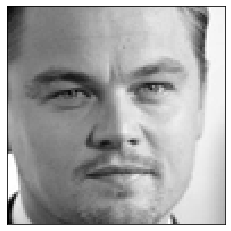

In [0]:
def plot_example(image_array, index):
  ax = plt.subplot(1,1,1)
  ax.imshow(image_array[index].reshape(96,96),cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
plot_example(train_images, 1800)

In [0]:
def plot_examples(num_examples, image_array):
  for i in range(num_examples):
    ax = plt.subplot(1,num_examples,i+1)
    ax.imshow(image_array[i].reshape(96,96),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# plot_examples(5,train_images)

In [0]:
def plot_index_list(image_array, print_list):
  '''
  print_list is list of indicies in train_array to print
  '''
  
  # only want to print first 10 if long list
  list_len = min(len(print_list),10)

  plt.figure(figsize=(10,10))
  for i, print_index in enumerate(print_list):
    if i >= 10: break
    plt.subplot(1, list_len, i+1)\
      .imshow(image_array[print_index].reshape(96,96),cmap='gray')
    plt.axis('off')
    
# plot_index_list(train_images, [1866, 2137, 1687])

In [0]:
print(np.unique([np.sum(pd.isnull(feature)) for feature in np.array(input_train_df.values)[:,0:30]], return_counts=True))

(array([ 0,  2,  4,  6,  8, 10, 12, 14, 20, 22, 24]), array([2140,   87,   28,    9,    8,    3,    5,    2,    2, 4755,   10]))


### Where do features tend to be on image?
* do any stand out as obviously bad?

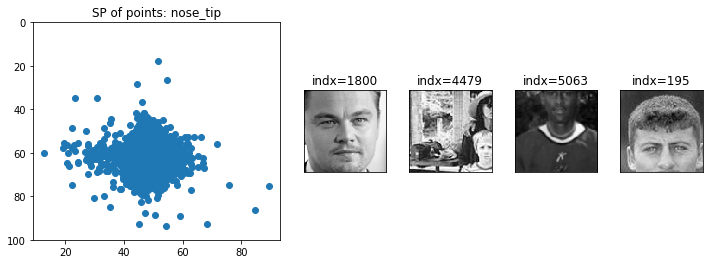

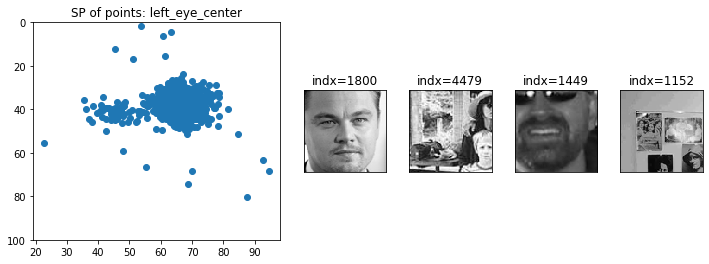

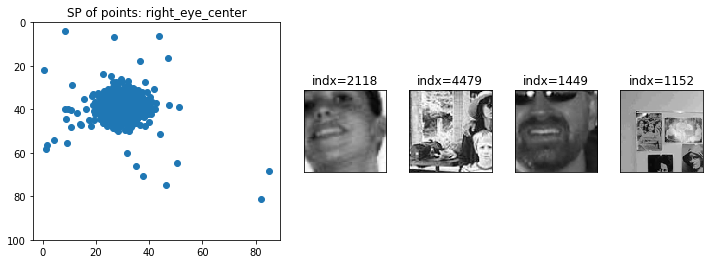

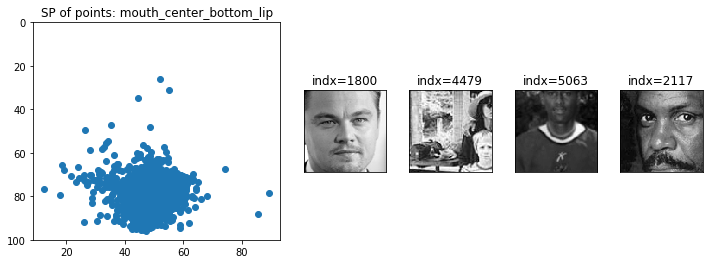

In [0]:
xy_feature_names = [
    'nose_tip',
    'left_eye_center',
    'right_eye_center',
    'mouth_center_bottom_lip'
]

for feature in xy_feature_names:
  x = train[feature+'_x'].values
  y = train[feature+'_y'].values

  min_x_index = np.nanargmin(train[feature+'_x'].values)
  max_x_index = np.nanargmax(train[feature+'_x'].values)
  min_y_index = np.nanargmin(train[feature+'_y'].values)
  max_y_index = np.nanargmax(train[feature+'_y'].values)

  figs_to_show = [
      min_x_index,
      max_x_index,
      min_y_index,
      max_y_index
  ]

  fig = plt.figure(figsize=(12, 4)) 
  gs = gridspec.GridSpec(1, 5, width_ratios=[3, 1, 1, 1, 1]) 
  ax0 = plt.subplot(gs[0])
  ax0.scatter(x, y)
  ax0.set_ylim((100, 0));
  ax0.set_title('SP of points: {}'.format(feature))

  for i, fig in enumerate(figs_to_show):
    ax = plt.subplot(gs[i+1])
    ax.imshow(train_images[fig].reshape(96,96),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("indx={}".format(fig))

In [0]:
# bad labels -- known poor labels in multiple areas
bad_labels_indexes = [
    1800,   
    
]



# bad images -- very dark, image off screen or extremely noisy, no image
bad_image_indexes = [
    4479,
    1152,
]

### Print some missing Left Eye Images

Left Eye Center missing


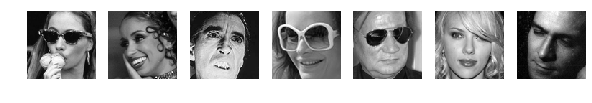

In [0]:
print('Left Eye Center missing')
feature_x = 'left_eye_center_x'
feature_y = 'left_eye_center_y'

# get indices of missing data -- print random sample
missing_list = train[train[feature_x].isnull() == True].index.tolist()
shuffle(missing_list)

plot_index_list(train_images, missing_list)

## Print some missing mouth images

Feature: nose_tip, # elements missing: 0
Feature: left_eye_center, # elements missing: 7
Feature: right_eye_center, # elements missing: 9
Feature: mouth_center_bottom_lip, # elements missing: 25


<Figure size 720x720 with 0 Axes>

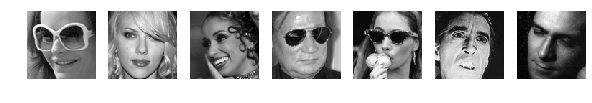

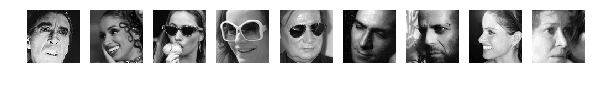

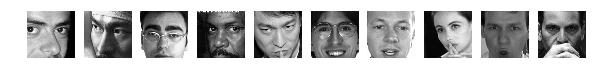

In [0]:
xy_feature_names = [
    'nose_tip',
    'left_eye_center',
    'right_eye_center',
    'mouth_center_bottom_lip'
]

for feature in xy_feature_names:
  feature_x = feature+"_x"
  feature_y = feature+"_y"

  # get indices of missing data -- print random sample
  missing_list = train[train[feature_x].isnull() == True].index.tolist()
  shuffle(missing_list)
  print('Feature: {}, # elements missing: {}'.format(feature, len(missing_list)))


  plot_index_list(train_images, missing_list)

Notes from above: 
* Mouth Images: Frequenty the mouth is actually missing from the picture. This would indicate that the proper treatment would be to omit it from being considered
* Eye images: generally missing for good reasons (glasses blocking, or hair blocking, or tilted such that getting a good read would be difficult)
<p>

  Takeaway: with more time, we may consider removing these images from consideration for the features that can't be properly detected (instead of doing the fill forward)

## **Check for Missing Data**


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 31 columns):
left_eye_center_x            5279 non-null float64
left_eye_center_y            5279 non-null float64
right_eye_center_x           5277 non-null float64
right_eye_center_y           5277 non-null float64
left_eye_inner_corner_x      1702 non-null float64
left_eye_inner_corner_y      1702 non-null float64
left_eye_outer_corner_x      1699 non-null float64
left_eye_outer_corner_y      1699 non-null float64
right_eye_inner_corner_x     1700 non-null float64
right_eye_inner_corner_y     1700 non-null float64
right_eye_outer_corner_x     1698 non-null float64
right_eye_outer_corner_y     1698 non-null float64
left_eyebrow_inner_end_x     1701 non-null float64
left_eyebrow_inner_end_y     1701 non-null float64
left_eyebrow_outer_end_x     1668 non-null float64
left_eyebrow_outer_end_y     1668 non-null float64
right_eyebrow_inner_end_x    1701 non-null float64
right_eyebrow_inner_end_y 

Above: Looks like eye centers, nose tip, and mouth center bottom are relatively well populated. Some of the  other points are much less well populated.

## **Forward Fill Missing Data**

Since the data has multiple columns of missing information we are going to input them using the forward fill method. Other methods: fill with median or mean. These may be things we would/could want to explore in the future.

Additionally, another possible approach could be to use some of the known data on the images to infer where the other pieces are (i.e. if mouth center bottom lip is known, we could use this to infer the right/left corner of the mouth better than the previous image) more sophisticated methodology may be to 

In [0]:
train = train.fillna(method = 'ffill').fillna(method='bfill')
dev = dev.fillna(method = 'ffill').fillna(method='bfill')

## Put together full feature list

In [0]:
full_feature_list = train.columns.tolist()
full_feature_list.remove('Image')

mouth_features = [
'mouth_left_corner_x',
'mouth_left_corner_y',
'mouth_right_corner_x',
'mouth_right_corner_y',
'mouth_center_top_lip_x',
'mouth_center_top_lip_y',
'mouth_center_bottom_lip_x',
'mouth_center_bottom_lip_y'
       ]

nose_features = [
 'nose_tip_x',
 'nose_tip_y'
]


right_eye_features = [
'right_eye_center_x',
'right_eye_center_y',
'right_eye_inner_corner_x',
'right_eye_inner_corner_y',
'right_eye_outer_corner_x',
'right_eye_outer_corner_y',
'right_eyebrow_inner_end_x',
'right_eyebrow_inner_end_y',
'right_eyebrow_outer_end_x',
'right_eyebrow_outer_end_y'
]


left_eye_features = [
'left_eye_center_x',
'left_eye_center_y',
'left_eye_inner_corner_x',
'left_eye_inner_corner_y',
'left_eye_outer_corner_x',
'left_eye_outer_corner_y',
'left_eyebrow_inner_end_x',
'left_eyebrow_inner_end_y',
'left_eyebrow_outer_end_x',
'left_eyebrow_outer_end_y'
    
]

feature_df = pd.DataFrame(full_feature_list, columns=['Features'])
# feature_df


#  Set up Principal Components (PCA)

In [0]:
nPCA_components = 60
pca = PCA(nPCA_components, svd_solver='randomized')
pca.fit(train_images)
print("Percent of Variance Explained", pca.explained_variance_ratio_.sum())
dev_components = pca.transform(dev_images)
train_components = pca.transform(train_images)
test_components = pca.transform(test_images)

Percent of Variance Explained 0.8743886313980461


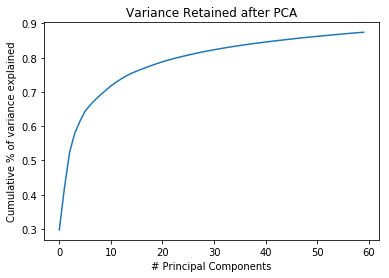

In [0]:
df = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance'])
df['cumulative_variance'] = df['Explained Variance'].cumsum()
df = df.reset_index()

fig = plt.figure()
ax = plt.axes()
ax.plot(df['cumulative_variance'])
ax.set_xlabel('# Principal Components')
ax.set_ylabel('Cumulative % of variance explained')
ax.set_title('Variance Retained after PCA');

In [0]:
print('shape of train', train_components.shape)
print('shape of dev', dev_components.shape)

shape of train (5286, 60)
shape of dev (1763, 60)


## Viewing PCA Images

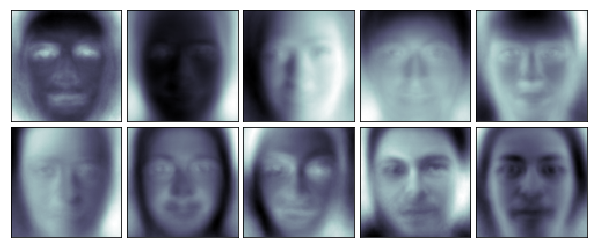

In [0]:
# View first 10 principal components
#Setup a figure 8 inches by 8 inches 
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
nPixels = 96
# plot the faces, each image is 87 by 87 pixels 
for i in range(10): 
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
  ax.imshow(np.reshape(pca.components_[i,:], (nPixels,nPixels)), 
            cmap=plt.cm.bone, interpolation='nearest')

# Modeling

## Baseline Model: Average Of All Images
Base model is just the median position of the feature in the given images

In [0]:
# Create model output and score on dev set (RMSE)
base_model = train.drop(columns='Image').median()

In [0]:
# now see how far off this base model was in mouth_left_corner_x (mse)
# could use full_feature_list

# mouth_features

base_acc = []
for feature in full_feature_list:
  pred_val = base_model[feature]
  nTimes_repeat = len(dev[feature])
  rmse = math.sqrt(metrics.mean_squared_error(dev[feature], 
                                              np.repeat(pred_val, nTimes_repeat)))
  base_acc.append(("Base (Avg Position)",feature, rmse))
  print('Feature: {}, rmse={}'.format(feature, rmse))

Feature: left_eye_center_x, rmse=3.3222642894626473
Feature: left_eye_center_y, rmse=3.0847171795992905
Feature: right_eye_center_x, rmse=3.096788211371273
Feature: right_eye_center_y, rmse=3.014278698589726
Feature: left_eye_inner_corner_x, rmse=2.0442826805085748
Feature: left_eye_inner_corner_y, rmse=2.318196123694883
Feature: left_eye_outer_corner_x, rmse=2.7331599581744697
Feature: left_eye_outer_corner_y, rmse=2.793481793774944
Feature: right_eye_inner_corner_x, rmse=3.043681819873754
Feature: right_eye_inner_corner_y, rmse=2.4259399626134033
Feature: right_eye_outer_corner_x, rmse=3.8415702312502846
Feature: right_eye_outer_corner_y, rmse=3.015803943226453
Feature: left_eyebrow_inner_end_x, rmse=3.1527140023940583
Feature: left_eyebrow_inner_end_y, rmse=3.238215593652716
Feature: left_eyebrow_outer_end_x, rmse=3.5988191238139797
Feature: left_eyebrow_outer_end_y, rmse=3.6659370908172098
Feature: right_eyebrow_inner_end_x, rmse=3.668941558171675
Feature: right_eyebrow_inner_end_y

In [0]:
base_acc[]

[('Base (Avg Position)', 'left_eye_center_x', 3.3222642894626473),
 ('Base (Avg Position)', 'left_eye_center_y', 3.0847171795992905),
 ('Base (Avg Position)', 'right_eye_center_x', 3.096788211371273),
 ('Base (Avg Position)', 'right_eye_center_y', 3.014278698589726),
 ('Base (Avg Position)', 'left_eye_inner_corner_x', 2.0442826805085748),
 ('Base (Avg Position)', 'left_eye_inner_corner_y', 2.318196123694883),
 ('Base (Avg Position)', 'left_eye_outer_corner_x', 2.7331599581744697),
 ('Base (Avg Position)', 'left_eye_outer_corner_y', 2.793481793774944),
 ('Base (Avg Position)', 'right_eye_inner_corner_x', 3.043681819873754),
 ('Base (Avg Position)', 'right_eye_inner_corner_y', 2.4259399626134033),
 ('Base (Avg Position)', 'right_eye_outer_corner_x', 3.8415702312502846),
 ('Base (Avg Position)', 'right_eye_outer_corner_y', 3.015803943226453),
 ('Base (Avg Position)', 'left_eyebrow_inner_end_x', 3.1527140023940583),
 ('Base (Avg Position)', 'left_eyebrow_inner_end_y', 3.238215593652716),
 

## Find Accuracy Model

In [0]:
def find_accuracy(model, feature_list, model_name='generic_name'):
  ''' assumes the following exist:
  train_components, 
  dev_componenets, 
  train[features] 
  dev[features]
  
  '''
  acc_scores = []
  
  for feature in feature_list:
    # fit model on train data with appropriate labels
    fitted_model = model.fit(train_components, train[feature])
    model_pred = fitted_model.predict(dev_components)
    rmse = math.sqrt(metrics.mean_squared_error(dev[feature], model_pred))
    acc_scores.append((model_name, feature, rmse))
#     print('Feature: {}, rmse={}'.format(feature, rmse))
  
  return acc_scores

## Run Models

In [0]:
ridge_model_acc = find_accuracy(Ridge(), mouth_features,  model_name='Ridge')
SGD_model_acc = find_accuracy(SGDRegressor(penalty='l1'), mouth_features,  
                              model_name='SGD')

## Using AutoML

In [0]:

# TODO - DON'T MAKE THIS PANDAS DF -- DO IT ALL IN NUMPY
# for feature in full_feature_list:
feature = 'mouth_center_top_lip_y'
temp_pre_h2o_df_train= pd.concat([train[feature].reset_index()\
                    .drop(columns='index'), 
                    pd.DataFrame(train_components)], axis=1)
temp_pre_h2o_df_train.to_csv('train_outfile.csv',index=False)

# do the same for dev
temp_pre_h2o_df_dev= pd.concat([dev[feature].reset_index()\
                    .drop(columns='index'), 
                    pd.DataFrame(dev_components)], axis=1)
temp_pre_h2o_df_dev.to_csv('dev_outfile.csv',index=False)

h2o.init()
h2o_train = h2o.import_file(path='train_outfile.csv')
h2o_train = h2o_train.drop([0],axis=0)
h2o_dev = h2o.import_file(path='dev_outfile.csv')
h2o_dev = h2o_dev.drop([0],axis=0)

aml = H2OAutoML(max_runtime_secs = 200)
y = "C1"
x = ["C"+str(n) for n in range(2,62)]

aml.train(x = x, y = y, training_frame=h2o_train, validation_frame=h2o_dev)

lb = aml.leaderboard
# lb.head()
lb.head(rows=lb.nrows)

# save leader
h2o.save_model(aml.leader, path = "./{}".format(feature))

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.3" 2019-04-16; OpenJDK Runtime Environment (build 11.0.3+7-Ubuntu-1ubuntu218.04.1); OpenJDK 64-Bit Server VM (build 11.0.3+7-Ubuntu-1ubuntu218.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4qgaq8iu
  JVM stdout: /tmp/tmp4qgaq8iu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4qgaq8iu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_unknownUser_z8tlur
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


'/content/mouth_center_top_lip_y/StackedEnsemble_AllModels_AutoML_20190815_014157'

In [0]:
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190813_211132,22.6703,4.76133,22.6703,3.63362,0.0639364
XGBoost_3_AutoML_20190813_211132,22.8023,4.77517,22.8023,3.65356,0.064098
StackedEnsemble_BestOfFamily_AutoML_20190813_211132,22.803,4.77525,22.803,3.65158,0.0641311
XGBoost_1_AutoML_20190813_211132,23.5607,4.85393,23.5607,3.69245,0.0651275
XGBoost_2_AutoML_20190813_211132,23.7878,4.87727,23.7878,3.69939,0.0654226
GLM_grid_1_AutoML_20190813_211132_model_1,24.1282,4.91205,24.1282,3.8074,0.0660753


In [0]:
# H2O instance for test set
h2o_test = h2o.H2OFrame(test_images)

# H2O prediction
preds = aml.predict(h2o_test)


Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
preds.shape
temp_list = full_feature_list[0:2]
results = pd.DataFrame(np.zeros((len(test_images),2)), columns=temp_list) 

In [0]:
preds_df = pd.DataFrame(preds)
results[temp_list[0]] = preds_df


In [0]:
temp_list = full_feature_list[0:2]
results = pd.DataFrame(np.zeros((len(test_images),2)), columns=temp_list) 

In [0]:
# for all features 
### temp_list = full_feature_list[0:2]

# H2O instance for test set
h2o_test = h2o.H2OFrame(test_images)

#for feature in temp_list:
for feature in full_feature_list:

  temp_pre_h2o_df_train= pd.concat([train[feature].reset_index()\
                      .drop(columns='index'), 
                      pd.DataFrame(train_components)], axis=1)
  temp_pre_h2o_df_train.to_csv('train_outfile.csv',index=False)

  # do the same for dev
  temp_pre_h2o_df_dev= pd.concat([dev[feature].reset_index()\
                      .drop(columns='index'), 
                      pd.DataFrame(dev_components)], axis=1)
  temp_pre_h2o_df_dev.to_csv('dev_outfile.csv',index=False)

  h2o.init()
  h2o_train = h2o.import_file(path='train_outfile.csv')
  h2o_train = h2o_train.drop([0],axis=0)
  h2o_dev = h2o.import_file(path='dev_outfile.csv')
  h2o_dev = h2o_dev.drop([0],axis=0)

  aml = H2OAutoML(max_runtime_secs = 200)
  y = "C1"
  x = ["C"+str(n) for n in range(2,62)]

  aml.train(x = x, y = y, training_frame=h2o_train, validation_frame=h2o_dev)

  lb = aml.leaderboard
  # lb.head()
  lb.head(rows=lb.nrows)

  # save leader
  h2o.save_model(aml.leader, path = "./{}".format(feature))
  
  # H2O prediction
  preds = aml.predict(h2o_test)
  preds_df = pd.DataFrame(preds)
  results[feature] = preds_df


H2OConnectionError: ignored

## Model Comparisons

In [0]:
# add model accuracy output to this list as models come online
model_accs = [base_acc, ridge_model_acc, SGD_model_acc]

model_scores = pd.DataFrame()
for model in model_accs:
  model_scores = pd.concat([model_scores, 
                            pd.DataFrame(model, 
                                         columns=['name','label','rmse'])])

# now find the improvement each has over the base

results = pd.pivot_table(model_scores, 
                     values='rmse', 
                     index='label', 
                     columns='name').reset_index()
results.columns = list(map(''.join, results.columns.values))
res_list = results.columns.tolist()
res_list.remove('label')

for col in res_list:
  results[col + "_pct_improvement"] = results[col] / results['Base (Avg Position)'] - 1
  
results

,label,Base (Avg Position),Ridge,SGD,Base (Avg Position)_pct_improvement,Ridge_pct_improvement,SGD_pct_improvement
0,mouth_center_bottom_lip_x,4.338084,3.389799,3.395104,0.0,-0.218595,-0.217373
1,mouth_center_bottom_lip_y,5.209687,4.208072,4.302841,0.0,-0.192260,-0.174069
2,mouth_center_top_lip_x,3.459157,3.436030,3.708500,0.0,-0.006686,0.072082
3,mouth_center_top_lip_y,5.419276,5.196598,5.352101,0.0,-0.041090,-0.012396
4,mouth_left_corner_x,3.507831,3.435308,3.655137,0.0,-0.020675,0.041993
5,mouth_left_corner_y,4.648344,4.489214,4.519922,0.0,-0.034234,-0.027627
6,mouth_right_corner_x,4.499139,4.427143,4.492120,0.0,-0.016002,-0.001560
7,mouth_right_corner_y,4.452952,4.302791,4.348498,0.0,-0.033722,-0.023457


# Test set

In [0]:
def predict_test(model):
  '''Predicts coordinates of all features with specified model
  Requires these:
  - train_components
  - test_components
  - full_feature_list
  '''
  predictions = []
  for feature in full_feature_list:

    fitted_model = model.fit(train_components, train[feature])
    model_pred = fitted_model.predict(test_components)
    predictions.append(model_pred)

  return predictions

#model = SGDRegressor(penalty='l1')

predicted_points = predict_test(SGDRegressor(penalty='l1'))

In [0]:
predicted_df = pd.DataFrame(zip(*predicted_points), columns=full_feature_list)
predicted_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,67.294401,37.506405,30.429019,36.181857,60.448453,37.800346,74.066806,37.814928,36.068885,37.630362,23.691044,38.688040,57.832860,28.416967,80.898443,29.184647,38.547849,26.153505,14.216908,28.870904,49.501362,56.072894,64.616939,75.000451,33.764587,74.299997,48.881069,73.245518,49.050778,82.709424
1,67.491966,36.216445,28.493824,38.290488,61.123614,38.694262,74.249066,37.738608,35.655920,38.454114,22.457537,38.898461,56.467420,30.361718,79.864378,29.480627,38.134291,29.908884,14.544694,29.683601,48.924233,62.470452,63.341015,77.622601,34.009689,78.783754,47.946559,75.980846,48.705769,80.860040
2,66.199297,35.614191,30.981973,36.071656,59.089764,37.952512,71.618117,36.582276,36.428488,37.686878,26.499141,37.131519,57.866997,29.336988,76.792177,29.080568,41.512232,30.572983,18.159338,29.413178,50.573516,58.756572,62.050383,74.250472,36.152510,75.056305,48.874853,71.484716,51.709823,82.299957
3,64.300062,40.313319,31.883244,39.342199,57.012161,38.196835,73.317847,38.902306,37.837646,39.229149,22.889729,38.629945,56.571535,29.421468,79.703222,30.254571,39.424533,29.684912,16.703618,35.026642,48.542406,56.199669,64.424185,76.098623,31.824646,75.525472,48.945840,69.036124,50.021670,84.270799
4,64.645685,37.506494,30.356716,37.754938,62.402123,38.294974,73.935750,38.243781,34.824050,38.105632,23.987348,39.671999,57.253507,29.734144,78.955842,29.841352,38.352977,27.030248,13.971495,30.211054,50.055781,56.006623,63.526158,76.172137,35.125412,76.406260,48.979001,75.164148,48.687163,82.438740


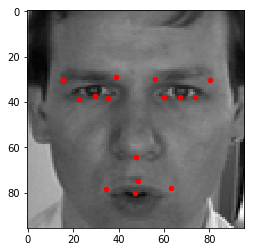

In [0]:
def plot_test(predicted_points, index):
  '''shows predicted features on image
  
  requires:
  - test_images'''
  x_points = []
  y_points = []

  # split into x coords and y coords
  for i in range(15):
    x_points.append(predicted_points[i*2][index])
    y_points.append(predicted_points[i*2+1][index])
    
  ax = plt.subplot(1,1,1)
  ax.imshow(test_images[index].reshape(96,96),cmap='gray')
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
  ax.scatter(x=x_points, y=y_points, c='r', s=20)

plot_test(predicted_points, 50)

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dense, Convolution2D,MaxPooling2D, GlobalAveragePooling2D
from google.colab import files
from keras import callbacks
from keras import optimizers
model = Sequential()

model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Convolution2D(24, 5, 5, border_mode="same", init='he_normal', input_shape=(96, 96, 1), dim_ordering='tf'))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid'))

model.add(Convolution2D(36, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid'))

model.add(Convolution2D(48, 5, 5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid'))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid'))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D());

model.add(Dense(500, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(30))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(96, 96, 1..., padding="same", data_format="channels_last", kernel_initializer="he_normal")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` ca

In [0]:
train_df_neg=train_df.fillna(value=0)
test_df_neg=test_df.fillna(value=0)
test_images_cnn=np.concatenate(np.array(test_df_neg["Image"].values)).ravel().reshape(test_df_neg.shape[0],96,96,1)

train_images_cnn=np.concatenate(np.array(train_df_clean.Image.values)).ravel().reshape(train_df_clean.shape[0],96,96,1)
train_features_cnn=np.array(train_df_clean.values)[:,0:30]
train_images_dirty=np.concatenate(np.array(train_df.Image.values)).ravel().reshape(train_df.shape[0],96,96,1)
train_features_dirty=np.array(train_df.values)[:,0:30]
train_images_neg=np.concatenate(np.array(train_df_neg.Image.values)).ravel().reshape(train_df_neg.shape[0],96,96,1)
train_features_neg=np.array(train_df_neg.values)[:,0:30]

In [0]:

Adam=optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#opt = SGD(lr=0.01, momentum=0.9)
file_checkpoint_name='face_model-adam-mse-0-lr005.h5'
#Nadam=optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

model.compile(optimizer=Adam, loss='mean_squared_error', metrics=['acc'])

checkpointer = callbacks.ModelCheckpoint(filepath=file_checkpoint_name, verbose=1, save_best_only=True)

epochs = 30

history = model.fit(train_images_neg, train_features_neg, validation_split=0.2, shuffle=True, epochs=epochs, batch_size=30, callbacks=[checkpointer], verbose=1)

#files.download(file_checkpoint_name)  

Train on 5639 samples, validate on 1410 samples
Epoch 1/30
5639/5639 [==============================] - 115s 20ms/step - loss: 598.5316 - mean_squared_error: 598.5316 - val_loss: 317.0164 - val_mean_squared_error: 317.0164

Epoch 00001: val_loss improved from inf to 317.01639, saving model to face_model-adam-mse-neg-lr0005.h5
Epoch 2/30
5639/5639 [==============================] - 113s 20ms/step - loss: 350.3465 - mean_squared_error: 350.3465 - val_loss: 345.6576 - val_mean_squared_error: 345.6576

Epoch 00002: val_loss did not improve from 317.01639
Epoch 3/30
5639/5639 [==============================] - 113s 20ms/step - loss: 312.9347 - mean_squared_error: 312.9347 - val_loss: 248.6072 - val_mean_squared_error: 248.6072

Epoch 00003: val_loss improved from 317.01639 to 248.60725, saving model to face_model-adam-mse-neg-lr0005.h5
Epoch 4/30
5639/5639 [==============================] - 112s 20ms/step - loss: 272.3273 - mean_squared_error: 272.3273 - val_loss: 342.8125 - val_mean_square

In [0]:

files.download(file_checkpoint_name) 


!ls

adc.json			      haarcascade_lefteye_2splits.xml
face_model-adam-mse-neg-lr0005.h5     haarcascade_profileface.xml
github.com			      haarcascade_righteye_2splits.xml
haarcascade_eye_tree_eyeglasses.xml   haarcascade_smile.xml
haarcascade_eye.xml		      sample_data
haarcascade_frontalface_alt2.xml      test.csv
haarcascade_frontalface_alt_tree.xml  train.csv
haarcascade_frontalface_default.xml


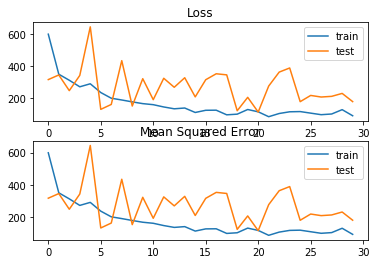

In [0]:
pyplot=plt
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot mse during training
pyplot.subplot(212)
pyplot.title('Accuracy')

pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()


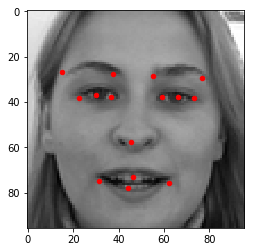

In [0]:
def plot_test_single(predicted_points,image, index):
  '''shows predicted features on image
  
  requires:
  - test_images'''
  x_points = []
  y_points = []

  # split into x coords and y coords
  for i in range(15):
    x_points.append(predicted_points[i*2])
    y_points.append(predicted_points[i*2+1])
    
  ax = plt.subplot(1,1,1)
  ax.imshow(image.reshape(96,96),cmap='gray')
  #ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
  ax.scatter(x=x_points, y=y_points, c='r', s=20)
index=200
predicted_points=model.predict(test_images_cnn[200].reshape(1,96,96,1), batch_size=1)
#predicted_points = model.predict(np.vstack(test_df['Image'].values).reshape(1783,96,96,1), batch_size=1783)
plot_test_single(predicted_points[0],test_images_cnn[200], index)


In [0]:
import cv2
from PIL import Image
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_lefteye_2splits.xml
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_righteye_2splits.xml
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_smile.xml

!wget -N https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_alt_tree.xml
!wget -N https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_profileface.xml

--2019-08-08 02:11:39--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2019-08-08 02:11:39 (5.97 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2019-08-08 02:11:40--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserc

In [0]:
#img = Image.fromarray(np.float32(train_images[10].reshape(96,96)), mode='F')
#from cv2 import cv
formatted = (np.float32(train_images[10].reshape(96,96)) * 255).astype('uint8')
img = Image.fromarray(formatted)
#grayscale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#face_cascade=cv2.CascadeClassifier("'My Drive'/colabs/haarcascade_frontalface_default.xml")
face_cascade=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
face_cascade_alt3=cv2.CascadeClassifier('haarcascade_frontalface_alt_tree.xml')
face_cascade_profile=cv2.CascadeClassifier('haarcascade_frontalface_alt_tree.xml')
eye_cascade_glasses=cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')
face_cascade_alt2=cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
eye_cascade_left=cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')
eye_cascade_right=cv2.CascadeClassifier('haarcascade_righteye_2splits.xml')
smile_cascade=cv2.CascadeClassifier('haarcascade_smile.xml')
bounding_boxes = face_cascade.detectMultiScale(formatted, 1.25, 6)


In [0]:
def cascade_boxes(images_raw):
  dev_formatted = (np.float32(images_raw.reshape(images_raw.shape[0],96,96)) * 255).astype('uint8')
  bounded_images=[]
  eyes_len=0
  faces_count=0

  for formatted in dev_formatted:
    
    bounding_boxes = face_cascade_alt2.detectMultiScale(formatted, 1.25, 6)
    if len(bounding_boxes)>0:
      faces_count=faces_count+1
    else:
      bounding_boxes=face_cascade_alt3.detectMultiScale(formatted, 1.25, 6)
      if len(bounding_boxes)>0:
        faces_count=faces_count+1
      else:
        bounding_boxes=face_cascade_profile.detectMultiScale(formatted, 1.1, 3)
        if len(bounding_boxes)>0:
          faces_count=faces_count+1
        else:
          bounding_boxes=face_cascade.detectMultiScale(formatted, 1.1, 3)

    
      #oi_color = img[y:y+h, x:x+w]
    bb_smile=smile_cascade.detectMultiScale(formatted, 1.25, 6)
    
    eyes=eye_cascade.detectMultiScale(formatted, 1.25, 3)
    eye1=eyes
    if (len(eyes)!=2):
      eyes=eye_cascade_glasses.detectMultiScale(formatted, 1.25, 3)
      eye2=eyes
      if (len(eyes)!=2):
        eyer=eye_cascade_right.detectMultiScale(formatted, 1.25, 3)
        eyel=eye_cascade_left.detectMultiScale(formatted, 1.25, 3)
        eyes=[eye[0] for eye in (eyer,eyel,eye1,eye2) if eye is not ()]
    for (ex,ey,ew,eh) in bb_smile:
      cv2.rectangle(formatted,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(formatted,(ex,ey),(ex+ew,ey+eh),(0,255,0),1)
        eyes_len+=1  
    for (x,y,w,h) in bounding_boxes:
      cv2.rectangle(formatted,(x,y),(x+w,y+h),(255,0,0),1)
      roi_gray = formatted[y:y+h, x:x+w]
      
    bounded_images.append(formatted)
  print(np.sum(eyes_len)/images_raw.shape[0]/2)
  print(faces_count/images_raw.shape[0])
  return bounded_images
def plot_example(num_examples,bounded_images):
  plt.figure(figsize=(20,20))
  for i in range(num_examples):
    ax = plt.subplot(1,num_examples,i+1)
    ax.imshow(bounded_images[i*15],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

0.49659671015314805
0.5127623369256948


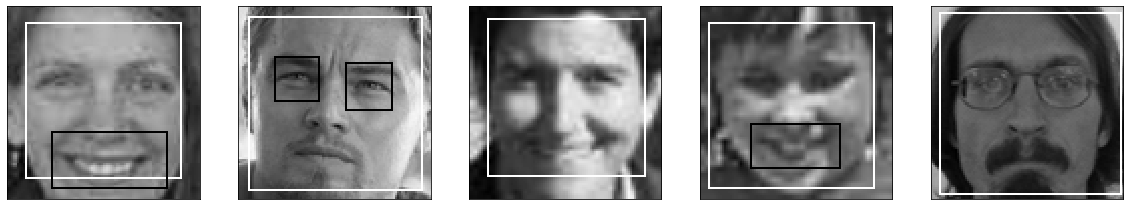

In [0]:

bounded_images=cascade_boxes(dev_images_raw)
plot_example(5,bounded_images)


0.5001891789632993
0.5085130533484676


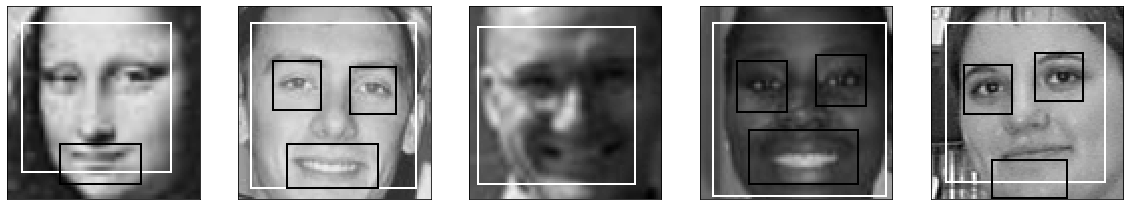

In [0]:
bounded_images=cascade_boxes(train_images)
plot_example(5,bounded_images)
